Import Libraries

In [1]:
import pandas as pd
import numpy as np
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

Load Italy Earthquake Data

In [2]:
def load_data(train_path, dev_path, test_path):
    train_df = pd.read_csv(train_path, sep="\t")
    dev_df = pd.read_csv(dev_path, sep="\t")
    test_df = pd.read_csv(test_path, sep="\t")

    # Combine train data and dev data for better training
    train_df = pd.concat([train_df, dev_df], ignore_index=True)
    return train_df, test_df

train_path = "/content/italy_earthquake_aug_2016_train.tsv"
dev_path = "/content/italy_earthquake_aug_2016_dev.tsv"
test_path = "/content/italy_earthquake_aug_2016_test.tsv"

train_df, test_df = load_data(train_path, dev_path, test_path)

In [3]:
train_df

,tweet_id,tweet_text,class_label
0,768531565475405824,@natekgarner Please nate DM me!! I need you #P...,sympathy_and_support
1,768972568237842432,NYC Italian Restuarants To Donate Sales Of Pas...,rescue_volunteering_or_donation_effort
2,768800509826248704,My heart goes out to all the victims in #Italy...,sympathy_and_support
3,768506687343001600,RT @NPR: Update: The death toll from the #Ital...,injured_or_dead_people
4,768844526505058305,RT @AllAccesstoSM: not from Italy but #PrayFor...,sympathy_and_support
...,...,...,...
957,768879948610281472,Seriously wondering if I can do anything to he...,rescue_volunteering_or_donation_effort
958,768500566544814080,Dead toll of Italys earthquake rises 120 victi...,injured_or_dead_people
959,768550755271835649,RT @OL_America: .#ItalyEarthquake #Outlander F...,rescue_volunteering_or_donation_effort
960,768478167287947264,RT @Bellisario85s: You can help Italy by donat...,rescue_volunteering_or_donation_effort


In [4]:
test_df

,tweet_id,tweet_text,class_label
0,768812549513080833,RT @SputnikInt: URGENT: #ItalyEarthquake death...,injured_or_dead_people
1,769041203115487232,RT @DisasterChannL: MT @emergenzavvf: #ItalyEa...,rescue_volunteering_or_donation_effort
2,768547619455074305,More Than 120 Dead In Italy Earthquake As Town...,injured_or_dead_people
3,768517185601990658,#BREAKING: Italian firefighter chief said a 8-...,rescue_volunteering_or_donation_effort
4,768513553728954368,@GraysonDolan @EthanDolan please Italy needs l...,requests_or_urgent_needs
...,...,...,...
234,768858230055313409,The Happiness Family continues to pray for tho...,sympathy_and_support
235,768493565995577344,"Heart, love and thoughts going out of my fello...",sympathy_and_support
236,768559306442698752,RT @jfkbydbay: My prayers to those affected by...,sympathy_and_support
237,769303673327325184,RT @romewise: Head to #italy museums Sunday to...,rescue_volunteering_or_donation_effort


ALL DATA

In [5]:
tweet_data = pd.concat([train_df, test_df], ignore_index=True)

In [6]:
tweet_data['class_label'].value_counts()

,count
class_label,
sympathy_and_support,579
rescue_volunteering_or_donation_effort,312
injured_or_dead_people,174
infrastructure_and_utility_damage,54
other_relevant_information,52
requests_or_urgent_needs,30


Data Preprocessing

In [7]:
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
    text = re.sub(r"\@\w+|\#", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = re.sub(r"\d+", "", text)
    return text.strip()

train_df["clean_text"] = train_df["tweet_text"].apply(clean_text)
test_df["clean_text"] = test_df["tweet_text"].apply(clean_text)

In [8]:
vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)
X_train = vectorizer.fit_transform(train_df["clean_text"])
X_test = vectorizer.transform(test_df["clean_text"])

In [9]:
label_mapping = {label: idx for idx, label in enumerate(train_df["class_label"].unique())}
y_train = train_df["class_label"].map(label_mapping)
y_test = test_df["class_label"].map(label_mapping)

Define confusion matrix

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, model_name, class_labels):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

    plt.xlabel("Predicted Labels", fontsize=10)
    plt.ylabel("Actual Labels", fontsize=10)
    plt.title(f"Confusion Matrix - {model_name}", fontsize=10)

    plt.xticks(rotation=90)
    plt.yticks(rotation=0)

    plt.show()

class_labels = list(label_mapping.keys())


In [11]:
def evaluate_model(y_true, y_pred, model_name):
    precision = precision_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    accuracy = accuracy_score(y_true, y_pred)
    print(f"\n{model_name} Evaluation:")
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'F1 Score: {f1}')

    print("\n Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_labels))

Decision Tree

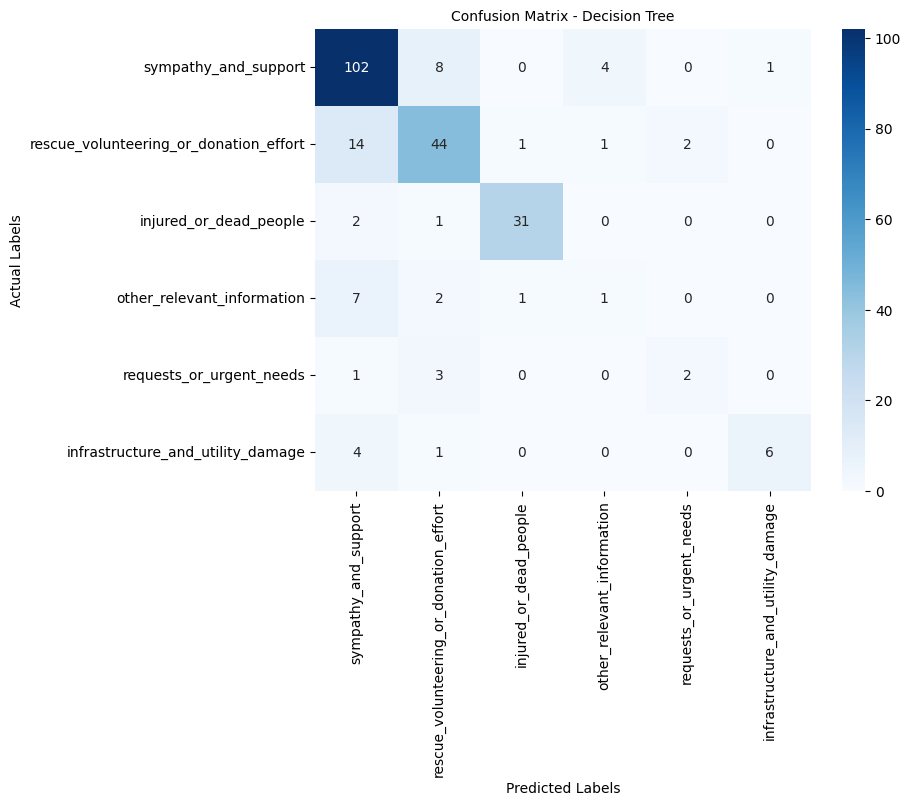


Decision Tree Evaluation:
Accuracy: 0.7782426778242678
Precision: 0.7643069291533939
F1 Score: 0.7670968563986684

 Classification Report:
                                        precision    recall  f1-score   support

                  sympathy_and_support       0.78      0.89      0.83       115
rescue_volunteering_or_donation_effort       0.75      0.71      0.73        62
                injured_or_dead_people       0.94      0.91      0.93        34
            other_relevant_information       0.17      0.09      0.12        11
              requests_or_urgent_needs       0.50      0.33      0.40         6
     infrastructure_and_utility_damage       0.86      0.55      0.67        11

                              accuracy                           0.78       239
                             macro avg       0.67      0.58      0.61       239
                          weighted avg       0.76      0.78      0.77       239



In [12]:
from sklearn.metrics import accuracy_score, classification_report, precision_score, f1_score, recall_score

dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
dt_preds = dt_model.predict(X_test)

plot_confusion_matrix(y_test, dt_preds, "Decision Tree", class_labels)
evaluate_model(y_test, dt_preds,"Decision Tree")


Random Forest

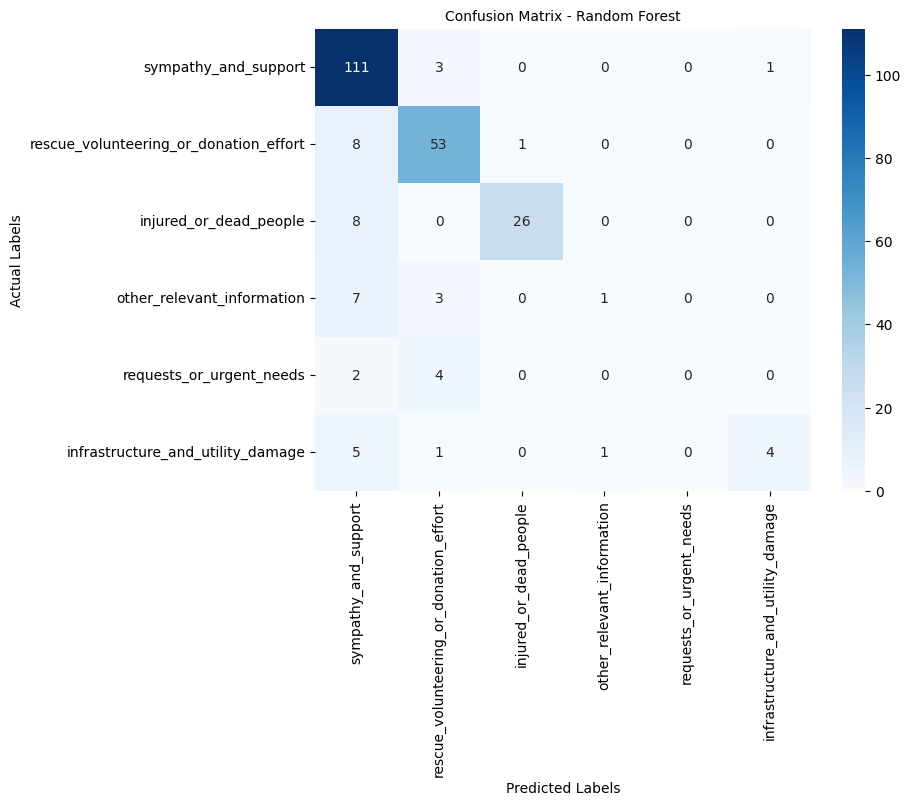


Random Forest Evaluation:
Accuracy: 0.8158995815899581
Precision: 0.7904452118592376
F1 Score: 0.7868669745121961

 Classification Report:
                                        precision    recall  f1-score   support

                  sympathy_and_support       0.79      0.97      0.87       115
rescue_volunteering_or_donation_effort       0.83      0.85      0.84        62
                injured_or_dead_people       0.96      0.76      0.85        34
            other_relevant_information       0.50      0.09      0.15        11
              requests_or_urgent_needs       0.00      0.00      0.00         6
     infrastructure_and_utility_damage       0.80      0.36      0.50        11

                              accuracy                           0.82       239
                             macro avg       0.65      0.51      0.54       239
                          weighted avg       0.79      0.82      0.79       239



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

In [13]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

plot_confusion_matrix(y_test, rf_preds, "Random Forest", class_labels)
evaluate_model(y_test, rf_preds,"Random Forest")

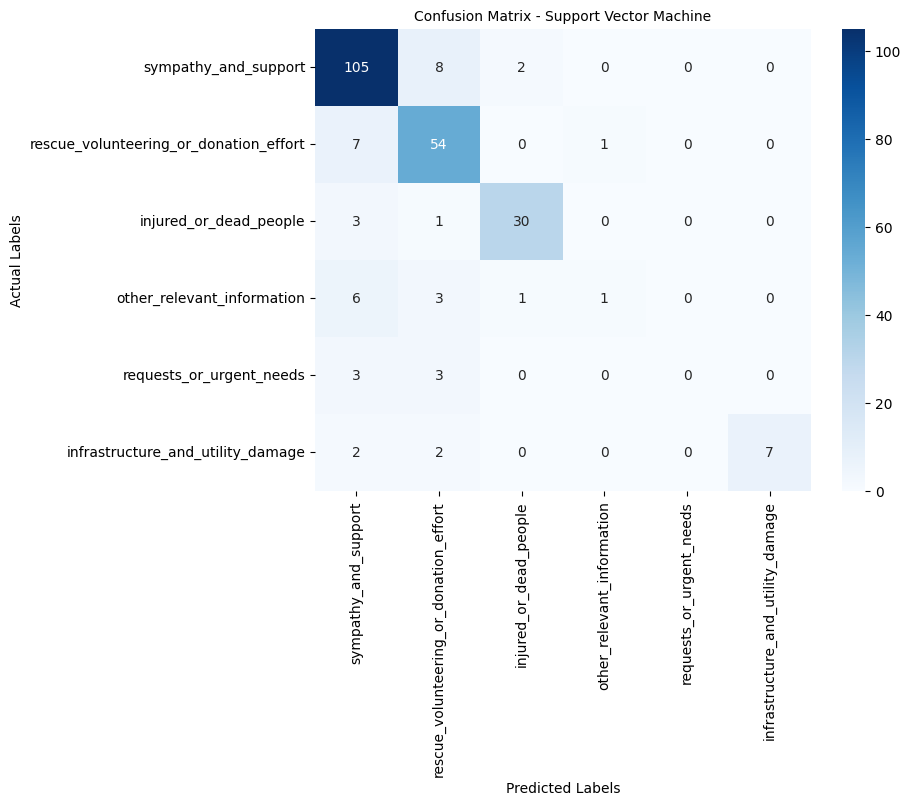


Support Vector Machine Evaluation:
Accuracy: 0.8242677824267782
Precision: 0.7966416477819626
F1 Score: 0.8002048451180555

 Classification Report:
                                        precision    recall  f1-score   support

                  sympathy_and_support       0.83      0.91      0.87       115
rescue_volunteering_or_donation_effort       0.76      0.87      0.81        62
                injured_or_dead_people       0.91      0.88      0.90        34
            other_relevant_information       0.50      0.09      0.15        11
              requests_or_urgent_needs       0.00      0.00      0.00         6
     infrastructure_and_utility_damage       1.00      0.64      0.78        11

                              accuracy                           0.82       239
                             macro avg       0.67      0.57      0.59       239
                          weighted avg       0.80      0.82      0.80       239



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

In [14]:
svm_model = SVC(kernel="linear", random_state=42)
svm_model.fit(X_train, y_train)
svm_preds = svm_model.predict(X_test)

plot_confusion_matrix(y_test, svm_preds, "Support Vector Machine", class_labels)
evaluate_model(y_test, svm_preds,"Support Vector Machine")